In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### cuda enable



In [47]:
import torch

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {device}")

# Enable CUDA support if available
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True


Using device: cuda


## Data Loading

In [48]:
import os  # when loading file paths
import pandas as pd  # for lookup in annotation file
import spacy  # for tokenizer
import torch
from torch.nn.utils.rnn import pad_sequence  # pad batch
from torch.utils.data import DataLoader, Dataset
from PIL import Image  # Load img
import torchvision.transforms as transforms

In [64]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]


class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform

        # Get img, caption columns
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]

        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(numericalized_caption)


class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        return imgs, targets


def get_loader(
    root_folder,
    annotation_file,
    transform,
    batch_size=256,
    num_workers=2,
    shuffle=True,
    pin_memory=True,
):
    dataset = FlickrDataset(root_folder, annotation_file, transform=transform)

    pad_idx = dataset.vocab.stoi["<PAD>"]

    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx),
    )

    return loader, dataset

In [65]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to a square image
    transforms.CenterCrop(224),     # Crop the center to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [66]:
loader, dataset = get_loader(
        "/content/drive/MyDrive/week4B/Images", "/content/drive/MyDrive/week4B/captions.txt", transform=transform
    )

# for idx, (imgs, captions) in enumerate(loader):
#     print(imgs.shape)
#     print(captions.shape)

# Model Architecture
- Our model has pretrained CNN VGG19 as encoder
- We deleted the last linear layer of model and made a layer which will output 256 (embedd size) vector
- This vector is submitted to DecoderNN which has 1 LSTM in final model to predict the next token (from vocab)

In [16]:
import torch
import torch.nn as nn
import statistics
import torchvision.models as models

class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        self.train_CNN = train_CNN
        self.vgg19 = models.vgg19(pretrained=True)

        # Remove only the last fully connected layer of VGG19
        vgg_classifier = list(self.vgg19.classifier.children())[:-1]
        self.vgg19.classifier = nn.Sequential(*vgg_classifier)

        # Add your own linear layer
        self.fc = nn.Linear(4096, embed_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

        # Set requires_grad to False for all parameters by default
        for param in self.parameters():
            param.requires_grad = train_CNN

        # Set requires_grad to True only for the last layer (self.fc)
        for param in self.fc.parameters():
            param.requires_grad = True

    def forward(self, images):
        features = self.vgg19(images)
        features = features.view(features.size(0), -1)
        features = self.fc(features)
        return self.dropout(self.relu(features))

In [17]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.2)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs

# the CNNtoRNN layer uses extracted features from CNN model and target tokens as input for each example for training

In [18]:
class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length=50):
        result_caption = []

        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None

            for _ in range(max_length):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)
                result_caption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0)

                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break

        return [vocabulary.itos[idx] for idx in result_caption]

# To save and load model

In [24]:
def save_checkpoint(state, filename="/content/drive/MyDrive/week4B/my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    step = checkpoint["step"]
    return step

In [20]:
!nvidia-smi

Mon Jan 29 08:54:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0              33W /  70W |    103MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Model Training

In [21]:
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

def train():
    torch.backends.cudnn.benchmark = True
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    load_model = False
    save_model = True
    train_CNN = False

    # Hyperparameters
    embed_size = 256
    hidden_size = 256
    vocab_size = len(dataset.vocab)
    num_layers = 1
    learning_rate = 3e-4
    num_epochs = 10

    # for tensorboard
    writer = SummaryWriter("runs/flickr")
    step = 0

    # initialize model, loss etc
    model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)


    if load_model:
        step = load_checkpoint(torch.load("my_checkpoint.pth.tar"), model, optimizer)

    model.train()

    for epoch in range(num_epochs):
        # Uncomment the line below to see a couple of test cases
        # print_examples(model, device, dataset)

        if save_model:
            checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "step": step,
            }
            save_checkpoint(checkpoint)

        for idx, (imgs, captions) in tqdm(
            enumerate(loader), total=len(loader), leave=False
        ):
            imgs = imgs.to(device)
            captions = captions.to(device)

            outputs = model(imgs, captions[:-1])
            loss = criterion(
                outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
            )

            writer.add_scalar("Training loss", loss.item(), global_step=step)
            step += 1

            optimizer.zero_grad()
            loss.backward(loss)
            optimizer.step()

In [22]:
train()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 93.8MB/s]


=> Saving checkpoint


=> Saving checkpoint


=> Saving checkpoint


=> Saving checkpoint


=> Saving checkpoint


=> Saving checkpoint


=> Saving checkpoint


=> Saving checkpoint


=> Saving checkpoint


=> Saving checkpoint


In [68]:
vocab =  dataset.vocab

# Examples

In [69]:
class Flickr_Dataset():
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform

        # Get img, caption columns
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]

    def __len__(self):
        return len(self.df)


    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_id))

        if self.transform is not None:
            img = self.transform(img)

        return img, caption

In [70]:
import random
dataset = Flickr_Dataset(root_dir="/content/drive/MyDrive/week4B/Images", captions_file="/content/drive/MyDrive/week4B/captions.txt")

In [71]:
random_indices = random.sample(range(len(dataset)), 20)

images_and_captions = []
for index in random_indices:
    image, caption = dataset[index]
    images_and_captions.append((image, caption))

True Caption: A black man is wearing sunglasses and a blue shirt with a white undershirt .
Predicted Caption: 
a man in a blue shirt and a black shirt and a black shirt and a woman in a white shirt and a black and white shirt and a black and white hat and a black and white dog is standing in front of a building . 


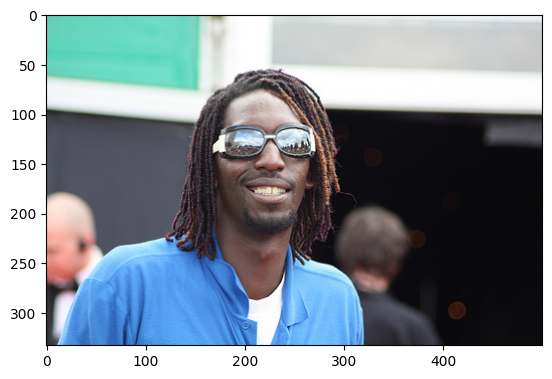

True Caption: A painted woman rides a bike in public .
Predicted Caption: 
a man in a red shirt and a black shirt and a black and white dog is standing in front of a building . 


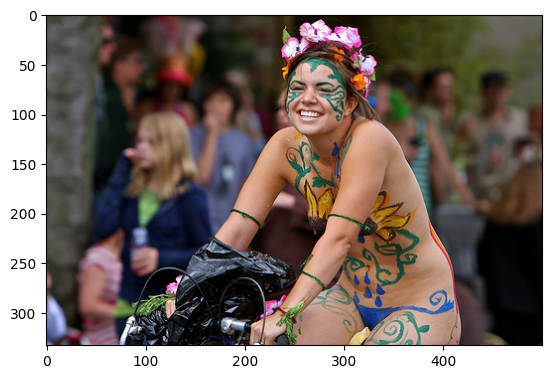

True Caption: A costumed woman with a sword does a backbend .
Predicted Caption: 
a man in a red shirt and a black shirt and a black shirt and a woman in a white shirt and a black and white shirt and a black and white hat and a black and white dog is standing in front of a building . 


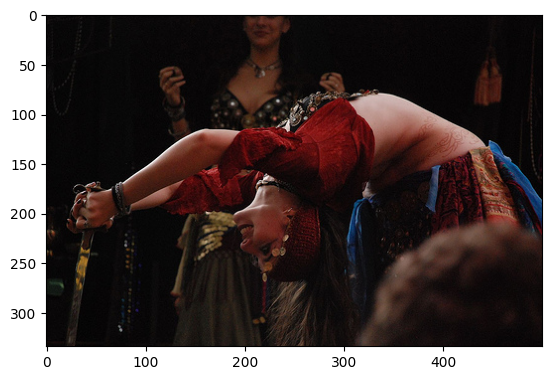

True Caption: Two brown dogs are running through the grass .
Predicted Caption: 
a dog is running through the grass . 


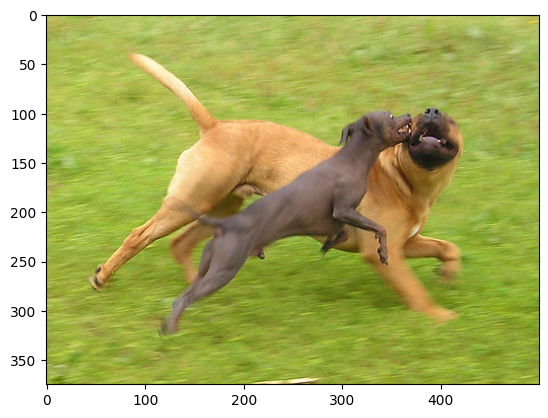

True Caption: Two dogs , the gray poodle high in the air , play on the grass .
Predicted Caption: 
a dog is running through the grass . 


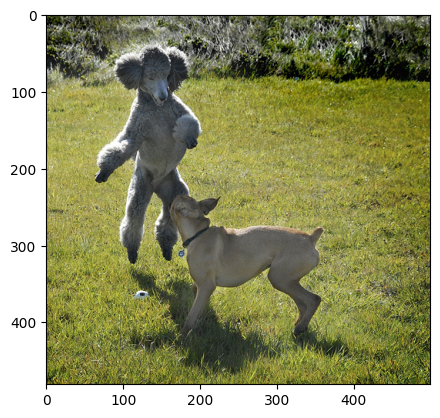

True Caption: A large bird is flying over water .
Predicted Caption: 
a black dog is running through the grass . 


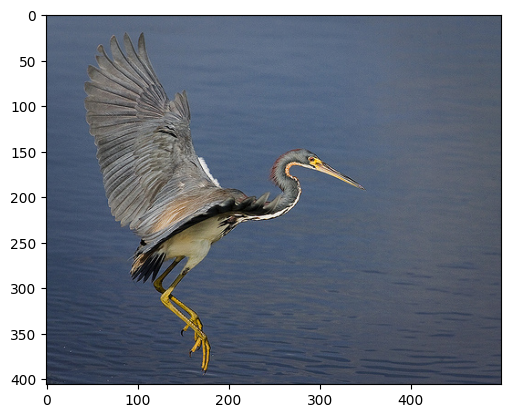

True Caption: These helmeted people are rock climbing outdoors .
Predicted Caption: 
a man in a red shirt is jumping over a rock . 


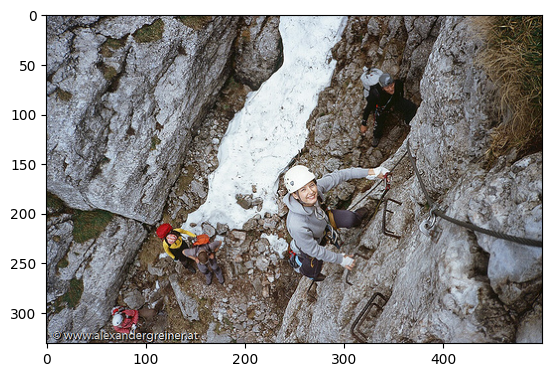

True Caption: a girl wearing pink pulls weeds .
Predicted Caption: 
a man in a red shirt and a black shirt is standing on a bench . 


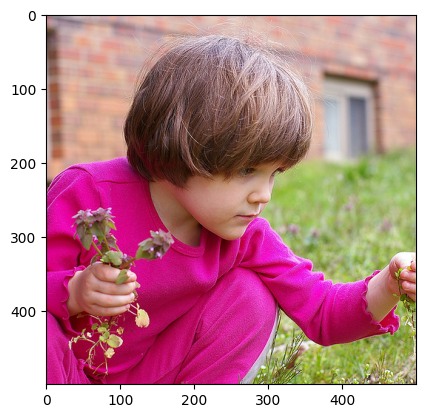

True Caption: Two young men walking together .
Predicted Caption: 
a man in a red shirt and a black shirt and a black shirt and a woman in a white shirt and a black and white shirt and a black and white hat and a black and white dog is standing in front of a building . 


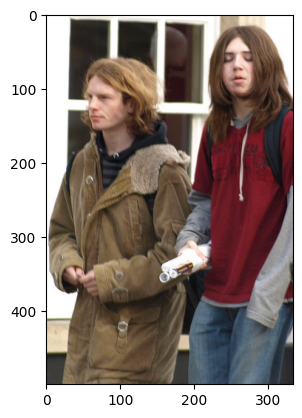

True Caption: Two white and brown dogs playing on a beach .
Predicted Caption: 
a dog is running through the grass . 


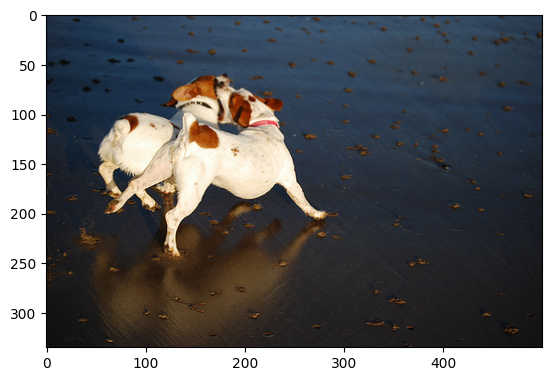

True Caption: A skateboarder attempts a trick with no shirt on .
Predicted Caption: 
a man in a red shirt is jumping over a rock . 


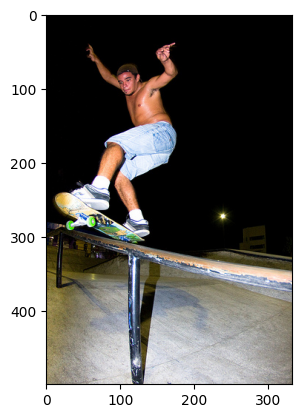

True Caption: A boy skateboarding in an urban area
Predicted Caption: 
a man in a red shirt is jumping over a rock . 


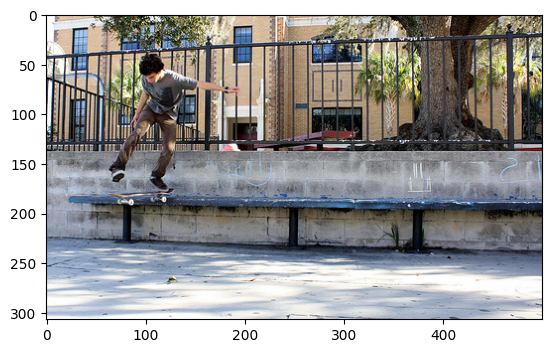

True Caption: A child in a white sox shirt is covered in water spray and looks distressed .
Predicted Caption: 
a man in a blue shirt and a black shirt and a black shirt and a woman in a white shirt and a black and white shirt and a black and white hat and a black and white dog is standing in front of a building . 


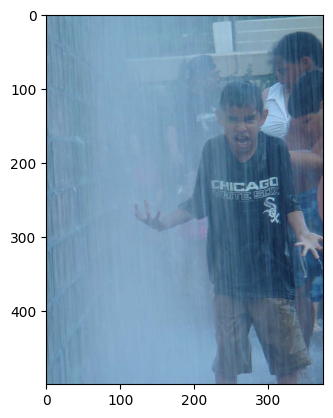

True Caption: Two golden dogs on a wood deck .
Predicted Caption: 
a dog is running through the grass . 


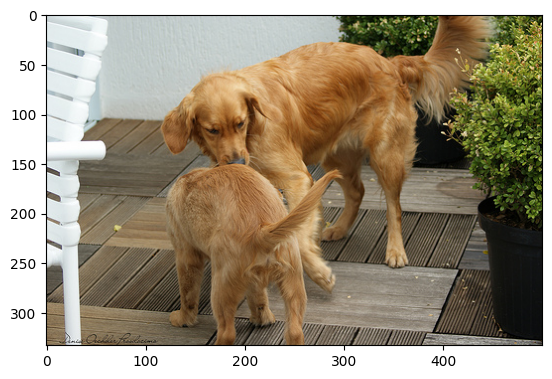

True Caption: Two men discuss a sign that says " Jesus or Hell " .
Predicted Caption: 
a man in a red shirt and a black shirt and a black shirt and a woman in a white shirt and a black shirt and a woman in a white shirt and a black and white shirt and a black and white hat and a woman in 


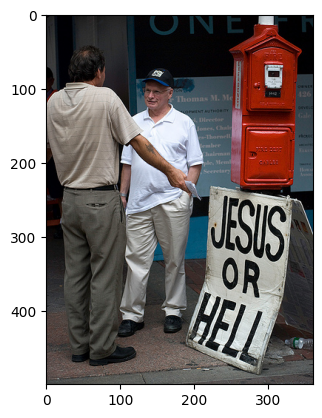

True Caption: A brown dog bares its fangs .
Predicted Caption: 
a dog is running through the grass . 


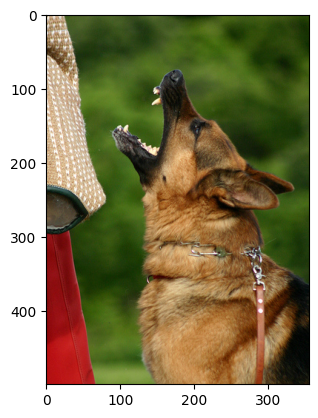

True Caption: A man in a black helmet riding his bike on a trail .
Predicted Caption: 
a man in a red shirt is jumping over a rock . 


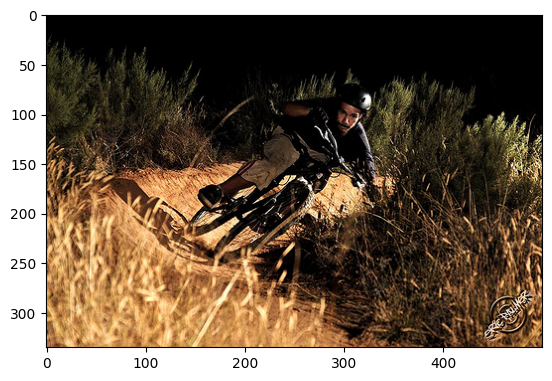

True Caption: A group of people outside having their picture taken
Predicted Caption: 
a man in a red shirt and a black shirt and a black shirt and a woman in a white shirt and a black shirt and a woman in a white shirt and a black and white shirt and a black and white hat and a woman in 


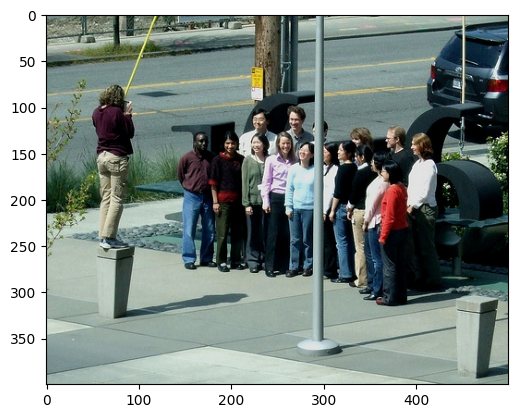

True Caption: The girl is in a red jersey and pitching a softball at a game .
Predicted Caption: 
a man in a white shirt and a black and white dog is running through the grass . 


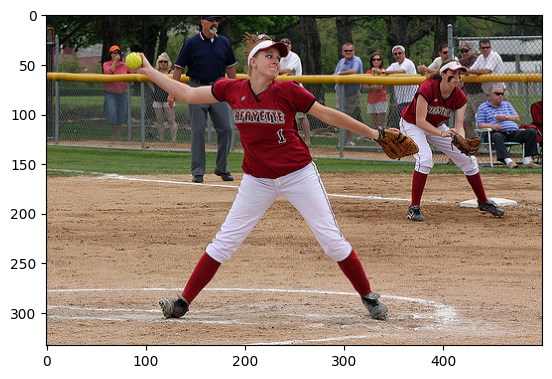

True Caption: Woman and dog cooling off at fountain
Predicted Caption: 
a dog is running through the grass . 


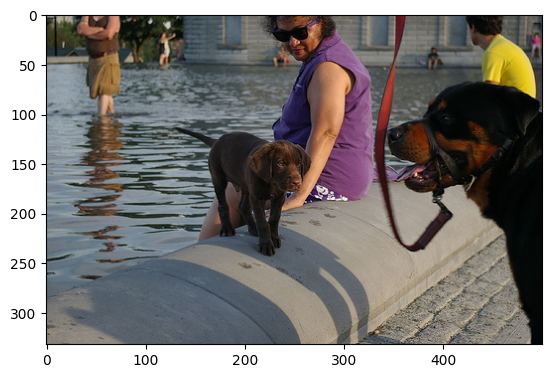

In [74]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),   # Resize to a square image
    transforms.CenterCrop(224),      # Crop the center to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

for idx, (img, caption) in enumerate(images_and_captions):
    # Ensure img is a tensor before applying transforms
    if not torch.is_tensor(img):
        img = transforms.ToTensor()(img)  # Convert to tensor if necessary

    # Display the image
    img_pil = transforms.ToPILImage()(img.cpu())
    plt.imshow(img_pil)

    # Apply transforms for model input
    img_tensor = transform(img_pil.convert("RGB")).unsqueeze(0)

    # Forward pass and predictions
    with torch.no_grad():
        predicted_caption = model.caption_image(img_tensor.to(device), vocab)
    predicted_caption = predicted_caption[1:-1]

    spaced_string = ""
    for item in predicted_caption:
      spaced_string += item + " "  # Append item and a space

    print(f'True Caption: {caption}\nPredicted Caption: ')
    print(spaced_string)
    plt.show()


# Conclusion
### - The model does not seems to accurately caption the image
### - There seems to be problem of overfitting as it is basically remebering a few phrases when it detect certain objects like dog, man, rock
### - I could not run this on my laptop due to lack of compute so I ran the program on Google collab
### - The model architecture could have been better if we used transformer for prediction instead of LSTM and I think instead of removing only last layer we should have removed last 2-3 layers as VGG19 is classification algorithm and till last layer it almost finalises the feature to be dog, cat, man, etc making it unable to convey broder picture
### - Could not experiment due to large compute time